# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [1]:
%matplotlib inline
import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tweepy  # you will need to install tweepy first

In [2]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
# authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))
# construct API instance, deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [19]:
username = 'appliedmldays'
user = api.get_user(username)
user_id = user.id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [194]:
def find_connections(userid, n=None):
    """
    Find connection for a given userid. (Both ID have to follow each other to be defined as connection,
    bi-directional edge)
    :param userid:  User to find connection with
    :param n:       Sampling factor
    :return:        Set of IDs connected to this user
    """
    # Query follower and following IDs
    try:
        followers = set(api.followers_ids(user_id=userid))
        followings = set(api.friends_ids(user_id=userid))
        connections = followers.intersection(followings)
        if n is not None:
            connections = set(np.random.permutation(list(connections))[0:n])
    except tweepy.TweepError:
        print('Can not access user properties')
        connections = set()
    return connections

In [206]:
first_connections = find_connections(user_id)
print('{} has {} connections'.format(username, len(first_connections)))

appliedmldays has 139 connections


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [262]:
def second_connections(userids, n=None):
    """
    Given a list IDs find connection for each of them
    :param userids: List of IDs to find connection for
    :param n: Number of ID to ramdonly pick from :connections:. If None, take all of them
    :return:    List of connections (2nd level)
    """
    N = n if n is not None else len(userids)
    connections = set()
    # Sample input if asked
    if n is not None:
        sel = np.random.permutation(list(userids))
    else:
        sel = list(userids)
    # Look for connections
    cnt = 0
    for ids in userids:
        conn = find_connections(ids, n) 
        if len(conn) > 0:
            connections = connections.union(conn)
            cnt += 1
            if cnt > N:
                break
    return connections

In [263]:
network={}
#This is the number of connections you are sampling.Keep small (e.g.3) for development, larger later (e.g. 10)
how_many = 15
# Collect first nodes (store in set for convenience)
first_nodes = find_connections(user_id, how_many)
second_nodes = second_connections(first_nodes, how_many)

Rate limit reached. Sleeping for: 461


**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [264]:
network[user_id] = first_nodes

In [265]:
pprint(network)

{763052115392593920: {25260440,
                      54089550,
                      79560366,
                      110071089,
                      215344270,
                      272511442,
                      381054288,
                      412275369,
                      2174341961,
                      2533212240,
                      2827458676,
                      2965901567,
                      3247516406,
                      4142688494,
                      885454501989294081}}


In [266]:
all_nodes = first_nodes.union(second_nodes)
all_nodes.add(user_id)

In [267]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 15 first hop nodes
There are 173 second hop nodes
There are overall 188 nodes in the collected network


In [268]:
for i in all_nodes:
     network[i]= set()

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [270]:
for ids in all_nodes:
    print('Search connections for {}'.format(ids))
    conn = find_connections(ids)
    conn = conn.intersection(all_nodes)
    network[ids] = network[ids].union(conn)
    for c in conn:
        network[c].add(ids)

Search connections for 715659434400333824
Search connections for 885454501989294081
Search connections for 821205828094939137
Search connections for 758236282531287040
Search connections for 845073891231981568
Rate limit reached. Sleeping for: 528
Search connections for 751679524614578176
Search connections for 709450714016301056
Search connections for 726504574547193856
Search connections for 824821752773693442
Search connections for 862774661603618816
Search connections for 763052115392593920
Search connections for 3000977415
Search connections for 198095876
Search connections for 885643395183525892
Search connections for 10169362
Search connections for 197593109
Search connections for 56455192
Search connections for 125637663
Search connections for 40189989
Search connections for 540776486
Rate limit reached. Sleeping for: 891
Search connections for 2318509094
Search connections for 94305347
Search connections for 2533212240
Search connections for 3072512080
Search connections for 1

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [271]:
# pprint(network)
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=np.int32)

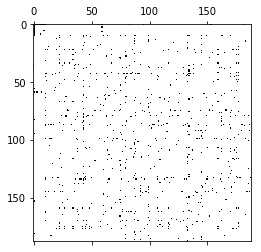

In [272]:
# your code here
nodes = list(all_nodes)
for i, ids in enumerate(nodes):
    conn = list(network[ids])
    for k in conn:
        j = nodes.index(k)
        W[i, j] = 1
plt.spy(W)

Remember that a weight matrix should be symmetric. Check if it is:

In [273]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:**
At the moment we are considering undriected edges since both people $i$ and $j$ have to follow each other, therefore the matrix will be symmetric. However if we consider undirected edges (i.e. Person $i$ is following $j$ but $j$ is not necessarly following $i$)  will end up with a non-symmetric matrix.

Impose your weight matrix to be symmetric.

In [274]:
# Make W is symmetric
bigger = W.transpose() > W

In [275]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

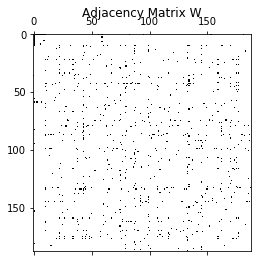

In [276]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**
From the definition:
$$L_{max} = \frac{N\left(N - 1\right)}{2}$$

In [277]:
Lmax = len(all_nodes) * (len(all_nodes) - 1) / 2
L = np.count_nonzero(W) / 2
print("Lmax is {}".format(Lmax))
print("L is {}".format(L))

Lmax is 17578.0
L is 376.0


## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

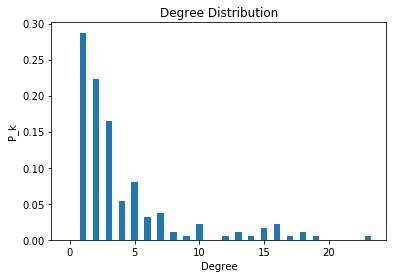

In [278]:
degree = []
for nodes in network.values():
    e = len(nodes)
    degree.append(e)
degree.sort()
max_degree = degree[-1]
p = [0] * (max_degree + 1)
for d in degree:
    p[d] += 1
# Normalize
p = list(map(lambda x: float(x) / sum(p), p))
xbin = np.arange(len(p))
plt.bar(xbin, p, align='center', width=0.5)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('P_k')
plt.show()

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:**

## 2.3 Average degree

Calculate the average degree of your collected network.

In [279]:
d_avg = 2 * L / len(all_nodes)
print('Average degree: {0:.3f}'.format(d_avg))

Average degree: 4.000


## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

$$\begin{align}d_{max} &= \max N_{i,j} \quad \forall i,j \\ &= 16\end{align}$$

In [280]:
def longer_path(net):
    nodes = list(net.keys())
    N = len(nodes)
    max_d = 0
    for i, node in enumerate(nodes):
        visited = [False] * N
        dist = [-1] * N
        stack = []
        stack.append(node)
        dist[i] = 0
        while len(stack) != 0:
            curr_n = stack.pop()
            curr_idx = nodes.index(curr_n)
            # Check if already visited
            if not visited[curr_idx]:
                visited[curr_idx] = True
                d = dist[curr_idx]
                # Label other
                childs = list(net[curr_n])
                for c in childs:
                    if dist[nodes.index(c)] == -1:
                        dist[nodes.index(c)] = d + 1
                    stack.append(c)
        max_d = max([max_d, max(dist)])
    return max_d

dmax = longer_path(network)
print('Network diameter: {}'.format(dmax))

Network diameter: 16


## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [281]:
# Find how many nodes have a degree higher than <k>
pruned_nodes = []
for ids, childs in network.items():
    k = len(childs)
    if k > d_avg:
        pruned_nodes.append(ids)
print('There are {} nodes left, initially {}'.format(len(pruned_nodes), len(all_nodes)))
# Init adjacency matrix with proper dimension + fill it
Wpruned = np.zeros([len(pruned_nodes),len(pruned_nodes)], dtype=np.int32)
for i, ids in enumerate(pruned_nodes):
    conn = list(network[ids])
    for k in conn:
        if k in pruned_nodes:
            j = pruned_nodes.index(k)
            Wpruned[i, j] = 1
# Sanity check
np.nonzero(Wpruned - Wpruned.transpose())

There are 51 nodes left, initially 188


(array([], dtype=int64), array([], dtype=int64))

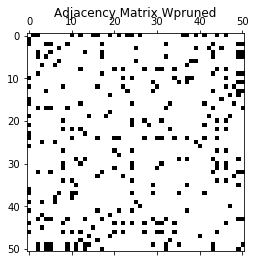

In [282]:
plt.title('Adjacency Matrix Wpruned')
plt.spy(Wpruned)